# Install Packages

In [0]:
!pip install cairocffi

     |████████████████████████████████| 71kB 5.3MB/s 
  Created wheel for cairocffi: filename=cairocffi-1.1.0-cp36-none-any.whl size=88591 sha256=0ece670af4a2cc84e88ea3556f33181352f5db5b21752d9e3511e2e2a55680c3
  Stored in directory: /root/.cache/pip/wheels/11/5e/47/167d9dfd5fa5850dd0cd3db80afe6db46e620edec3419dce5a
Successfully built cairocffi


# Import Function & Packages

In [1]:
import os
import glob
import numpy as np
# from tensorflow.keras import layers
from keras import layers

from tensorflow import keras
import tensorflow as tf
import re
import matplotlib.pyplot as plt
from random import randint
import urllib.request
import pandas as pd

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import tensorflow
from keras import Sequential, Model
from keras.layers import Embedding, LSTM, Dense, Input, Concatenate, Activation
from keras.activations import softmax
from keras.utils import to_categorical

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from sklearn.ensemble import RandomForestClassifier                                                                                                                                                                                 
from sklearn.model_selection import train_test_split                                                                                         
from sklearn.metrics import classification_report                                                                                              
from sklearn.metrics import confusion_matrix                                                                                                           
from mlxtend.plotting import plot_confusion_matrix 

import cairocffi as cairo
import numpy as np
import cairocffi as cairo



Using TensorFlow backend.


In [0]:
import numpy as np
import cairocffi as cairo

def train_remake(array):
    res = []
    for row in array:
        res += [row]
    return res

def vector_to_raster(vector_images, side=28, line_diameter=16, padding=16, bg_color=(0,0,0), fg_color=(1,1,1)):
    """
    padding and line_diameter are relative to the original 256x256 image.
    """
    
    original_side = 256.
    
    surface = cairo.ImageSurface(cairo.FORMAT_ARGB32, side, side)
    ctx = cairo.Context(surface)
    ctx.set_antialias(cairo.ANTIALIAS_BEST)
    ctx.set_line_cap(cairo.LINE_CAP_ROUND)
    ctx.set_line_join(cairo.LINE_JOIN_ROUND)
    ctx.set_line_width(line_diameter)

    # scale to match the new size
    # add padding at the edges for the line_diameter
    # and add additional padding to account for antialiasing
    total_padding = padding * 2. + line_diameter
    new_scale = float(side) / float(original_side + total_padding)
    ctx.scale(new_scale, new_scale)
    ctx.translate(total_padding / 2., total_padding / 2.)

    raster_images = []
    for vector_image in vector_images:
        # clear background
        ctx.set_source_rgb(*bg_color)
        ctx.paint()
        bbox = np.hstack(vector_image).max(axis=1)#1
        offset = ((original_side, original_side) - bbox) / 2.
        offset = offset.reshape(-1,1)
        centered = [stroke + offset for stroke in vector_image]

        # draw strokes, this is the most cpu-intensive part
        ctx.set_source_rgb(*fg_color)        
        for xv, yv in centered:
            ctx.move_to(xv[0], yv[0])
            for x, y in zip(xv, yv):
                ctx.line_to(x, y)
            ctx.stroke()

        data = surface.get_data()
        raster_image = np.copy(np.asarray(data)[::4])
        raster_images.append(raster_image)
    
    return raster_images
    
def unpack_drawing(file_handle):
    key_id, = unpack('Q', file_handle.read(8))
    # word, = unpack('s', file_handle.read(2))
    countrycode, = unpack('2s', file_handle.read(2))
    recognized, = unpack('b', file_handle.read(1))
    timestamp, = unpack('I', file_handle.read(4))
    n_strokes, = unpack('H', file_handle.read(2))
    image = []
    for i in range(n_strokes):
        n_points, = unpack('H', file_handle.read(2))
        fmt = str(n_points) + 'B'
        x = list(unpack(fmt, file_handle.read(n_points)))
        y = list(unpack(fmt, file_handle.read(n_points)))
        image.append((x, y))

        

    return {
        'key_id': key_id,
        'countrycode': countrycode,
        'recognized': recognized,
        'image': image
    }


def unpack_drawings(filename):
    with open(filename, 'rb') as f:
        while True:
            try:
                yield unpack_drawing(f)
            except struct.error:
                break

In [0]:
import struct
from struct import unpack


def unpack_drawing(file_handle):
    key_id, = unpack('Q', file_handle.read(8))
    # word, = unpack('s', file_handle.read(2))
    countrycode, = unpack('2s', file_handle.read(2))
    recognized, = unpack('b', file_handle.read(1))
    timestamp, = unpack('I', file_handle.read(4))
    n_strokes, = unpack('H', file_handle.read(2))
    image = []
    for i in range(n_strokes):
        n_points, = unpack('H', file_handle.read(2))
        fmt = str(n_points) + 'B'
        x = list(unpack(fmt, file_handle.read(n_points)))
        y = list(unpack(fmt, file_handle.read(n_points)))
        image.append((x, y))

        

    return {
        'key_id': key_id,
        'countrycode': countrycode,
        'recognized': recognized,
        'image': image
    }


def unpack_drawings(filename):
    with open(filename, 'rb') as f:
        while True:
            try:
                yield unpack_drawing(f)
            except struct.error:
                break



# Import Data
Extract Quick, Draw! data in npy type from Google Cloud Storage and store it in Google Drive.

## Dowload Data

In [0]:
!mkdir data

In [0]:
# connect to Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
classes = ['ear','eye','face','mouth','nose']
class_mapping = {'ear': 0,'eye': 1,'face': 2,'mouth': 3,'nose': 4}
image_size = 28

In [0]:

def download():
    base = 'https://storage.googleapis.com/quickdraw_dataset/full/binary/'
    for c in classes:
        # cls_url = c.replace('_', '%20')
        path = base+c+'.bin'
        print(path)
        urllib.request.urlretrieve(path, 'data/'+c+'.bin')
download()

https://storage.googleapis.com/quickdraw_dataset/full/binary/ear.bin
https://storage.googleapis.com/quickdraw_dataset/full/binary/eye.bin
https://storage.googleapis.com/quickdraw_dataset/full/binary/face.bin
https://storage.googleapis.com/quickdraw_dataset/full/binary/mouth.bin
https://storage.googleapis.com/quickdraw_dataset/full/binary/nose.bin


In [0]:
all_files = glob.glob(os.path.join('data', '*.bin'))

In [0]:
# Get image data
countrycode = []
recognized = []
word = []
image = []
image_vector = []
for i in all_files:
  for drawing in unpack_drawings(i):
      if (drawing['recognized'] == 1)  :
        word += [re.findall(r'[a-z]+',i)[1]]
        countrycode += re.findall(r'[A-Z][A-Z]',str(drawing['countrycode']))
        image += vector_to_raster([drawing['image']],side = image_size )
        image_vector += [image]
      else :
        continue

# Store the data in a dataframe
raw_data = pd.DataFrame()
raw_data['word'] = [class_mapping[x] for x in word]
raw_data['image'] = image
raw_data['image_vector'] = image_vector
raw_data['countrycode'] = countrycode

Then we save the data to Google Drive so we don't need to downlaod data at each time

In [0]:
np.save("gdrive/My Drive/big_data_all.npy", raw_data)

## Load Data from Google Drive

In [0]:
data = pd.DataFrame(np.load("gdrive/My Drive/big_data.npy",allow_pickle=True))

In [0]:
raw_data = pd.DataFrame()
raw_data['word'] = data.iloc[:,0]
raw_data['image'] = data.iloc[:,1]

# Predict Categories

## Traditional ML Model - Random Forest

In [0]:
x = train_remake(raw_data['image'])
y = train_remake(raw_data['word'])
# split data into train test
x_train,x_test,y_train,y_test = train_test_split(x,y\
                                                 ,test_size=0.3, random_state=55)

# train model
rfc = RandomForestClassifier(n_jobs=-1)                                                                                                                
rfc.fit(x_train, y_train)   

# fit the test data
pred = rfc.predict(x_test)                                                                                                                             

# results                                                                                                                                                      
report = classification_report(y_test, pred)                                                                                                           
confusion_mat = confusion_matrix(y_test, pred)


print(report)   
print(confusion_mat)


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


              precision    recall  f1-score   support

           0       0.92      0.92      0.92     34997
           1       0.86      0.89      0.87     36398
           2       0.89      0.90      0.90     44459
           3       0.92      0.87      0.89     37755
           4       0.97      0.96      0.96     54828

    accuracy                           0.91    208437
   macro avg       0.91      0.91      0.91    208437
weighted avg       0.91      0.91      0.91    208437

[[32205   261  1502   143   886]
 [  262 32472  1471  1928   265]
 [ 1361  1838 40145   767   348]
 [  141  3006  1448 32762   398]
 [ 1022   370   656   205 52575]]


In [0]:
 # fit the test data
pred = rfc.predict(x_train)     
print(classification_report(y_train, pred)) 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     81814
           1       1.00      1.00      1.00     84632
           2       1.00      1.00      1.00    103977
           3       1.00      0.99      1.00     88278
           4       1.00      1.00      1.00    127649

    accuracy                           1.00    486350
   macro avg       1.00      1.00      1.00    486350
weighted avg       1.00      1.00      1.00    486350



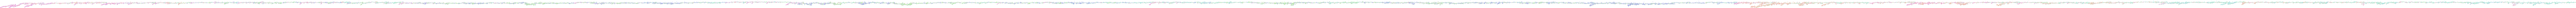

In [0]:
# Extract single tree
estimator = rfc.estimators_[5]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot',
                feature_names = [str(num) for num in list(range(1,785))],
                class_names = [str(num) for num in y_train],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

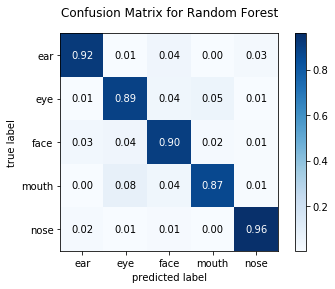

In [0]:
fig, ax = plot_confusion_matrix(conf_mat=confusion_mat,
                                colorbar=True,
                                show_absolute=False,
                                show_normed=True)
ax.xaxis.set_ticklabels(['','ear','eye','face','mouth','nose'])
ax.yaxis.set_ticklabels(['','ear','eye','face','mouth','nose'])
plt.title("Confusion Matrix for Random Forest")
# plt.show()
plt.savefig('gdrive/My Drive/confusion_matrix_rf.png')

## CNN Model


### Split data into train and test

In [0]:
# randomize data
data_rnd = shuffle(raw_data)
x = train_remake(data_rnd['image'])
y = data_rnd['word']

In [0]:
x_train,x_test,y_train,y_test = train_test_split(x,y\
                                                 ,test_size=0.3, random_state=4552)
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

### Reshape and Normalize

In [0]:
# Reshape and normalize
x_train = x_train.reshape(x_train.shape[0], image_size, image_size, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], image_size, image_size, 1).astype('float32')

x_train /= 255.0
x_test /= 255.0

# Convert class vectors to class matrices
y_train = keras.utils.to_categorical(y_train, len(classes))
y_test = keras.utils.to_categorical(y_test, len(classes))

### Build model

In [0]:
# Define model

model = keras.Sequential()
model.add(keras.layers.Convolution2D(16, (3, 3),
                        padding='same',
                        input_shape=x_train.shape[1:], activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Convolution2D(32, (3, 3), padding='same', activation= 'relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Convolution2D(64, (3, 3), padding='same', activation= 'relu'))
model.add(keras.layers.MaxPooling2D(pool_size =(2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(len(classes), activation='softmax')) 
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________

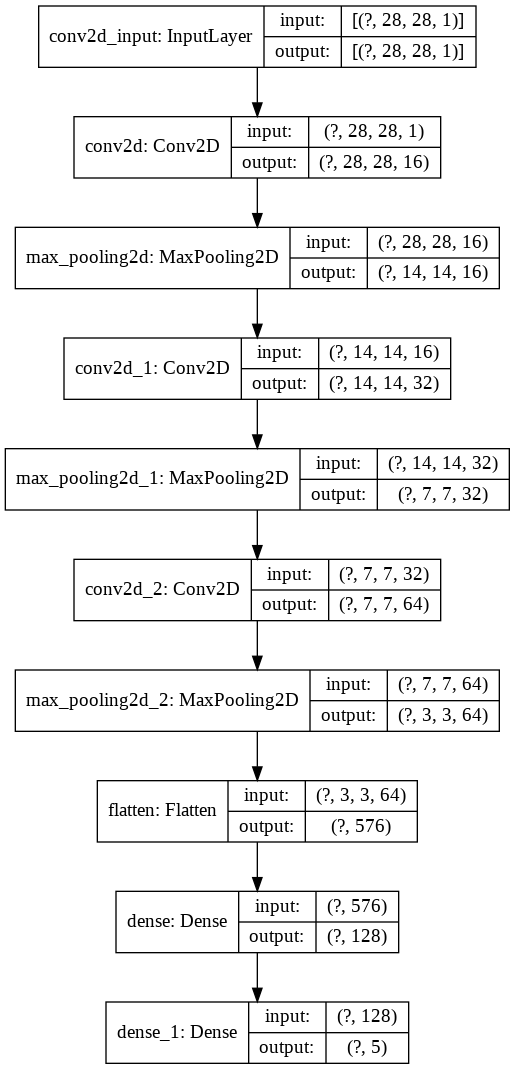

In [0]:
from keras.utils import plot_model
tf.keras.utils.plot_model(model, to_file='gdrive/My Drive/cnn_word_classfication_model.png', show_shapes=True) 

In [0]:
# Train model
# adam = tf.optimizers.AdamOptimizer(lr=0.01, beta_2 = 0.99999)
filepath = "gdrive/My Drive/model.{epoch:02d}-{val_acc:.3f}.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, 
                                                save_best_only=True, mode='max')
callbacks_list = [checkpoint]
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

### Train Model

In [0]:
BATCH_SIZE = 256
model.fit(x = x_train, y = y_train, \
          validation_split=0.1, \
          batch_size = BATCH_SIZE, \
          verbose=2, epochs=5,callbacks = callbacks_list)


Train on 437715 samples, validate on 48635 samples
Epoch 1/5

Epoch 00001: val_acc improved from 0.98038 to 0.98067, saving model to gdrive/My Drive/model.01-0.981.h5
437715/437715 - 9s - loss: 0.0457 - acc: 0.9845 - val_loss: 0.0606 - val_acc: 0.9807
Epoch 2/5

Epoch 00002: val_acc improved from 0.98067 to 0.98250, saving model to gdrive/My Drive/model.02-0.983.h5
437715/437715 - 9s - loss: 0.0418 - acc: 0.9857 - val_loss: 0.0540 - val_acc: 0.9825
Epoch 3/5

Epoch 00003: val_acc did not improve from 0.98250
437715/437715 - 9s - loss: 0.0387 - acc: 0.9869 - val_loss: 0.0581 - val_acc: 0.9813
Epoch 4/5

Epoch 00004: val_acc did not improve from 0.98250
437715/437715 - 9s - loss: 0.0352 - acc: 0.9880 - val_loss: 0.0617 - val_acc: 0.9808
Epoch 5/5

Epoch 00005: val_acc did not improve from 0.98250
437715/437715 - 9s - loss: 0.0324 - acc: 0.9889 - val_loss: 0.0626 - val_acc: 0.9815


In [0]:
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.03848924784849774
Test accuracy: 0.9873535


In [0]:
# serialize model to JSON
model_json = model.to_json()
with open("gdrive/My Drive/model.json", "w") as json_file:
    json_file.write(model_json)
model.load_weights('gdrive/My Drive/model.03-0.983.h5') 
model.save_weights("gdrive/My Drive/model.h5")

In [0]:
# model = load_model("gdrive/My Drive/model.json")
model.load_weights("gdrive/My Drive/model.h5")

In [0]:
# get the predict result in labels in test dataset
pred = model.predict(x_test.reshape(x_test.shape[0], \
                                    image_size, image_size, 1).astype('float32'))
pred_res = np.argmax(pred, axis=1)
y_test_res = np.argmax(y_test, axis=1)

# results                                                                                                                                                      
report = classification_report(y_test_res, pred_res)                                                                                                           
confusion_mat = confusion_matrix(y_test_res, pred_res)

print(report)   
print(confusion_mat)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     35033
           1       0.98      0.99      0.99     36212
           2       0.99      0.99      0.99     44638
           3       0.99      0.99      0.99     37622
           4       0.99      0.99      0.99     54932

    accuracy                           0.99    208437
   macro avg       0.99      0.99      0.99    208437
weighted avg       0.99      0.99      0.99    208437

[[34450    97    93    28   365]
 [   29 35769    75   284    55]
 [  101   107 44171   141   118]
 [   17   340    79 37122    64]
 [  460    64   113    70 54225]]


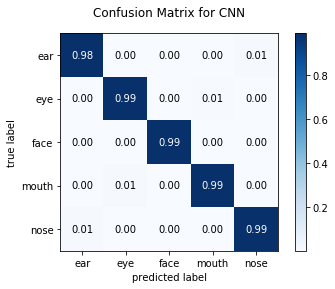

In [0]:
fig, ax = plot_confusion_matrix(conf_mat=confusion_mat,
                                colorbar=True,
                                show_absolute=False,
                                show_normed=True)
ax.xaxis.set_ticklabels(['','ear','eye','face','mouth','nose'])
ax.yaxis.set_ticklabels(['','ear','eye','face','mouth','nose'])
plt.title("Confusion Matrix for CNN")
plt.savefig('gdrive/My Drive/confusion_matrix_cnn.png')
# plt.show()

# Model Comparison

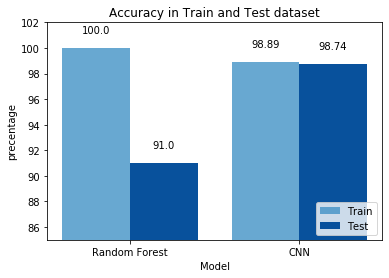

In [0]:
label_list = ['Random Forest','CNN']
num_list = [100,98.89]
num_list1 = [91,98.74]
x =list(range(len(num_list)))

rects1 = plt.bar(x, num_list, width=0.4, alpha=0.8, color= "#4292c6", label="Train")
rects2 = plt.bar([i + 0.4 for i in x], num_list1, width=0.4, color= "#08519c", label="Test")
plt.ylim(85, 102)     
plt.ylabel("precentage")

plt.xticks([index + 0.2 for index in x], label_list)
plt.xlabel("Model")
plt.title("Accuracy in Train and Test dataset")
plt.legend(loc='lower right',ncol=1)    

for rect in rects1:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2, height+1, str(height), ha="center", va="bottom")
for rect in rects2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2, height+1, str(height), ha="center", va="bottom")
# plt.show()

# plt.savefig('gdrive/My Drive/cnn_accuracy.png')
plt.savefig('cnn_accuracy.png')
